In [35]:
import cv2 as cv
from matplotlib import pyplot as plt
import json
import numpy as np

In [36]:
config = json.load(open("../config.json"))
print(config)
antrenare_folder = "../../antrenare/"
evaluare_folder = "../../evaluare/"
auxiliare_folder = "../../imagini_auxiliare/"

{'scoreBoard': [1, 2, 3, 4, 5, 6, 0, 2, 5, 3, 4, 6, 2, 2, 0, 3, 5, 4, 1, 6, 2, 4, 5, 5, 0, 6, 3, 4, 2, 0, 1, 5, 1, 3, 4, 4, 4, 5, 0, 6, 3, 5, 4, 1, 3, 2, 0, 0, 1, 1, 2, 3, 6, 3, 5, 2, 1, 0, 6, 6, 5, 2, 1, 2, 5, 0, 3, 3, 5, 0, 6, 1, 4, 0, 6, 3, 5, 1, 4, 2, 6, 2, 3, 1, 6, 5, 6, 2, 0, 4, 0, 1, 6, 4, 4, 1, 6, 6, 3, 100]}


In [37]:
def show_image(image):
    image = cv.resize(image, (0, 0), fx=0.3, fy=0.3)
    cv.imshow("image", image)
    cv.waitKey(0)
    cv.destroyAllWindows()


def print_image(image, gray=True, fft=True, title=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    if not gray:
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        axes[0].imshow(image_rgb)
        image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        axes[0].imshow(image, cmap="gray")
        image_gray = image
    axes[0].set_title("Image")
    axes[0].axis("off")

    if fft:
        f = np.fft.fft2(image_gray)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1e-60)
        axes[1].imshow(magnitude_spectrum, cmap="gray")
        axes[1].set_title("Spectrum")
        axes[1].axis("off")
    else:
        axes[1].remove()

    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def generate_2d_anisotropic_gaussian_kernel(size_x, size_y, sigma_x, sigma_y):
    center_x, center_y = size_x // 2, size_y // 2
    x, y = np.meshgrid(np.arange(size_x), np.arange(size_y), indexing="ij")
    x_squared = ((x - center_x) ** 2) / (2 * sigma_x**2)
    y_squared = ((y - center_y) ** 2) / (2 * sigma_y**2)
    kernel = np.exp(-(x_squared + y_squared))
    return kernel


base_img = cv.imread("./tabla_negoala.jpg")

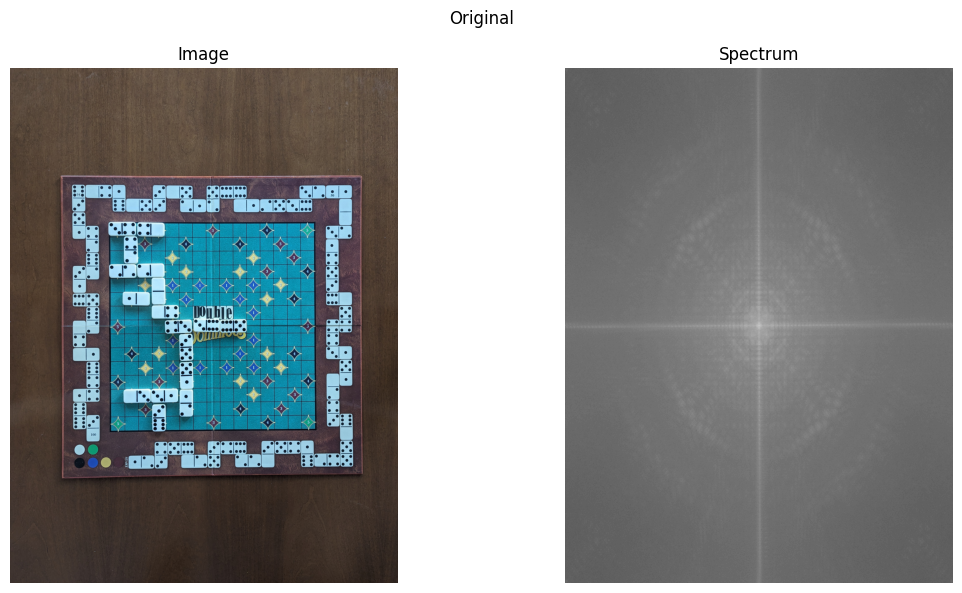

In [38]:
image = base_img
print_image(image, gray=False, title="Original")

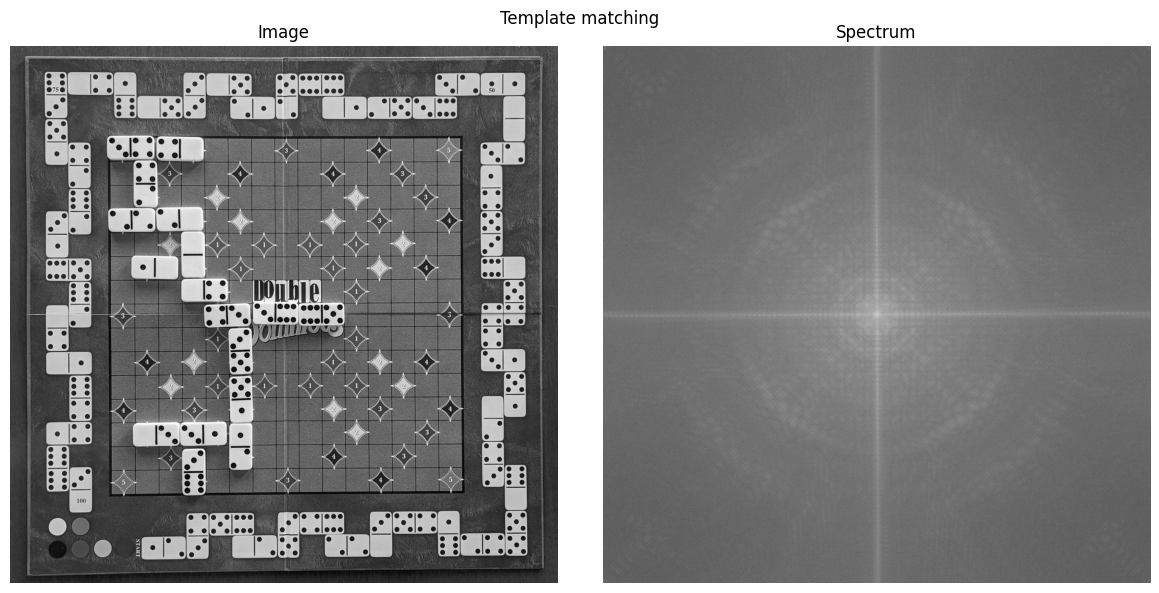

In [39]:
image_copy = cv.cvtColor(image.copy(), cv.COLOR_BGR2RGB)
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
template = cv.imread("../template_tabla.jpg", cv.IMREAD_GRAYSCALE)
w, h = template.shape[::-1]
method = cv.TM_SQDIFF_NORMED
res = cv.matchTemplate(image_gray, template, method)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
    top_left = min_loc
else:
    top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
image_gray = image_gray[top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]]
image_copy = image_copy[top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]]
print_image(image_gray, title="Template matching")

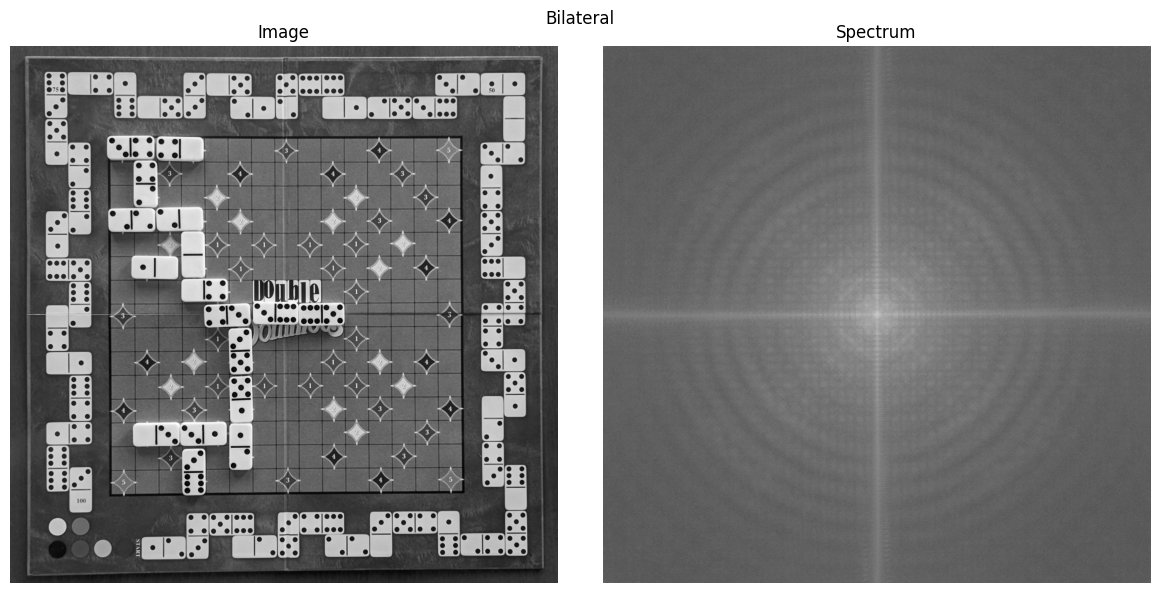

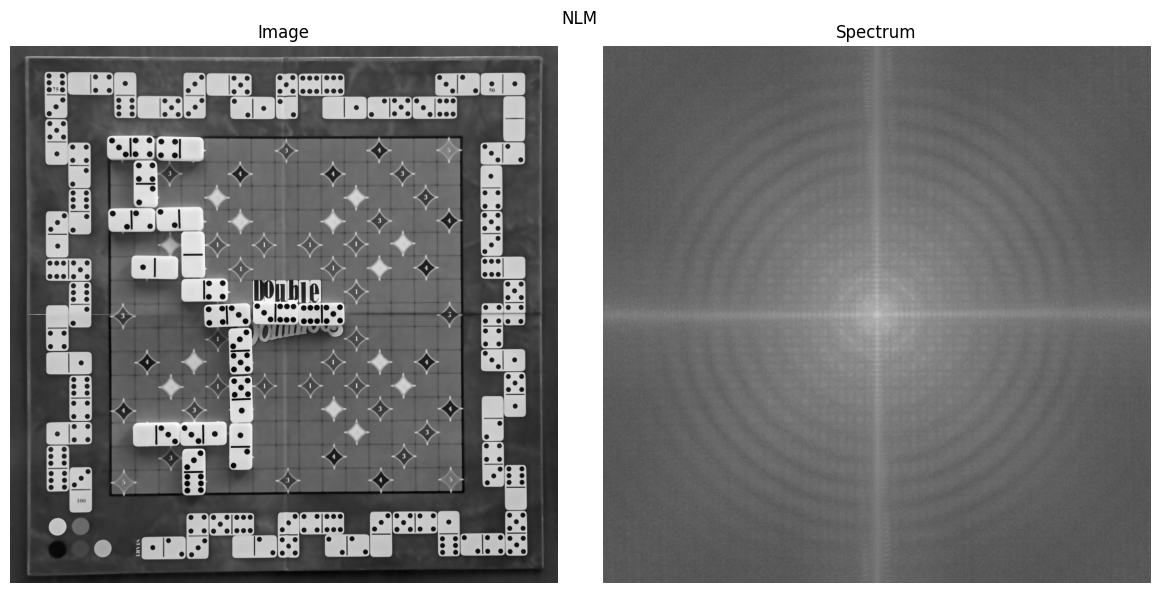

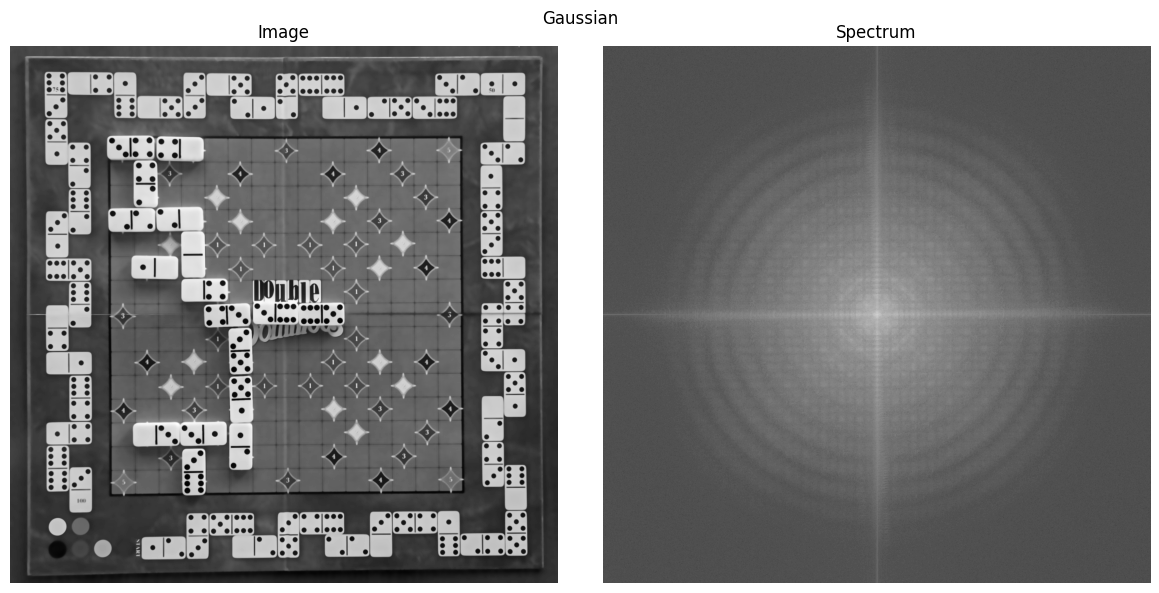

In [40]:
bilateral_filtered = cv.bilateralFilter(image_gray, d=9, sigmaColor=75, sigmaSpace=75)
print_image(bilateral_filtered, title="Bilateral")

nlm_denoised = cv.fastNlMeansDenoising(bilateral_filtered, None, 30, 7, 21)
print_image(nlm_denoised, title="NLM")

image_blurred = cv.GaussianBlur(nlm_denoised, (3, 3), 0)
print_image(image_blurred, title="Gaussian")

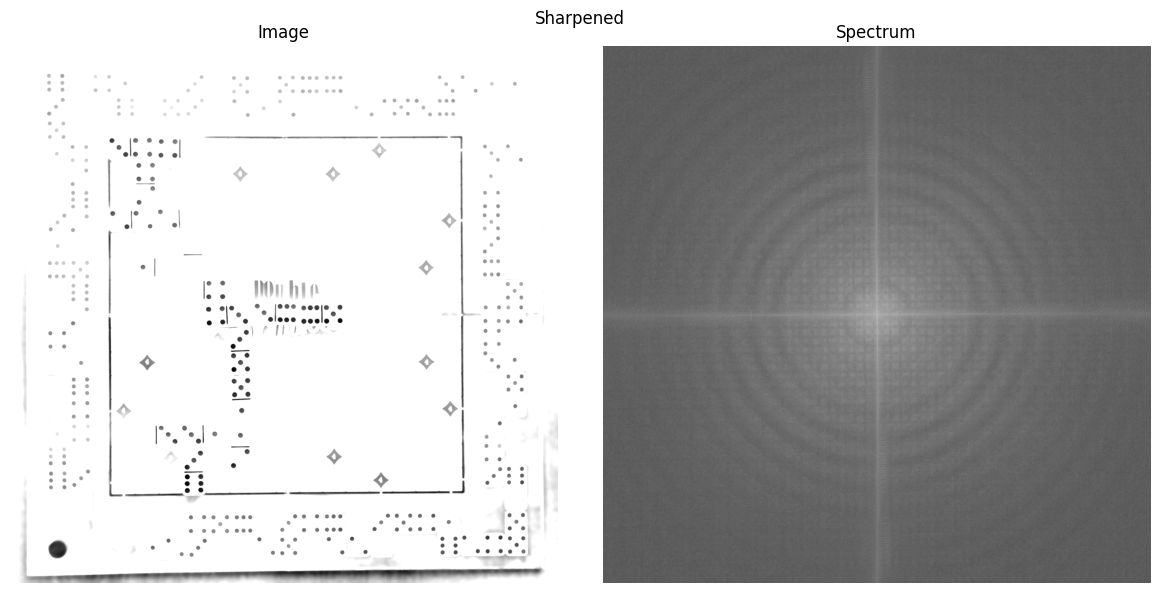

In [41]:
def sharpen(image):
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
    image_sharpened = cv.filter2D(image, -1, kernel)
    image_sharpened = cv.normalize(
        image_sharpened, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX
    )
    return image_sharpened


image_sharpened = sharpen(image_blurred)
print_image(image_sharpened, title="Sharpened")

255 0


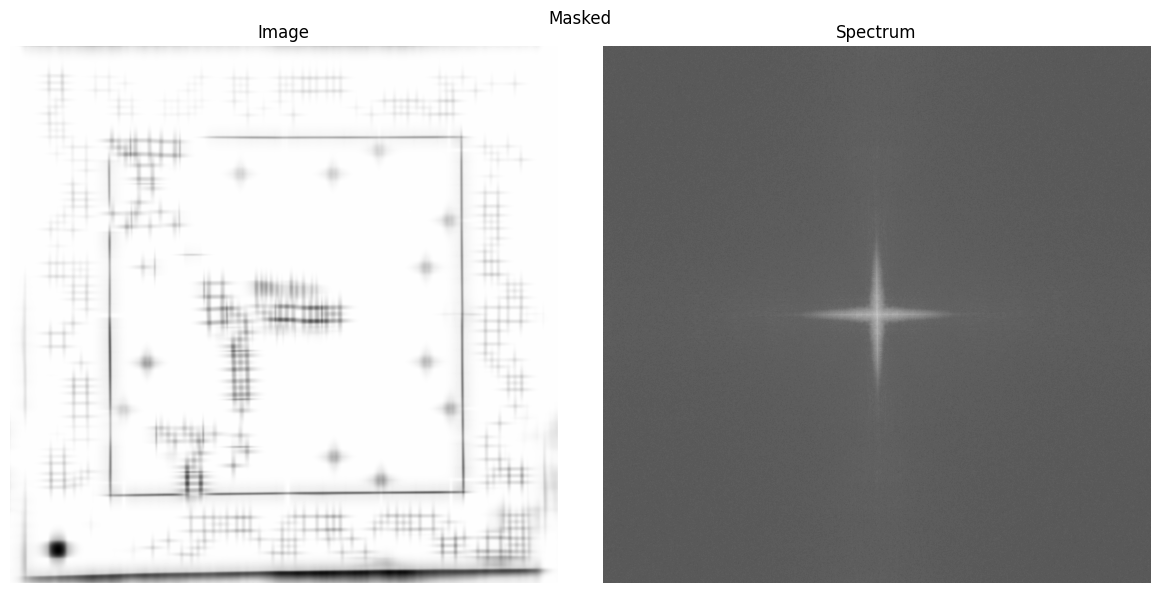

In [42]:
def mask(image):
    length = image.shape[0] // 20
    thick = image.shape[1] // 200

    rows, cols = image.shape
    gaussian_kernel_y = generate_2d_anisotropic_gaussian_kernel(
        rows, cols, length, thick
    )
    gaussian_kernel_x = generate_2d_anisotropic_gaussian_kernel(
        rows, cols, thick, length
    )
    gaussian_kernel_cross = gaussian_kernel_x + gaussian_kernel_y

    dft = cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)

    mask = np.zeros_like(dft_shifted)
    mask[:, :, 0] = gaussian_kernel_cross
    mask[:, :, 1] = gaussian_kernel_cross

    fshift = dft_shifted * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv.idft(f_ishift)
    img_back = cv.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    image_masked = cv.normalize(
        img_back, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX
    )

    return np.uint8(image_masked)


image_masked = mask(image_sharpened)
print(np.max(image_masked), np.min(image_masked))
print_image(image_masked, title="Masked")

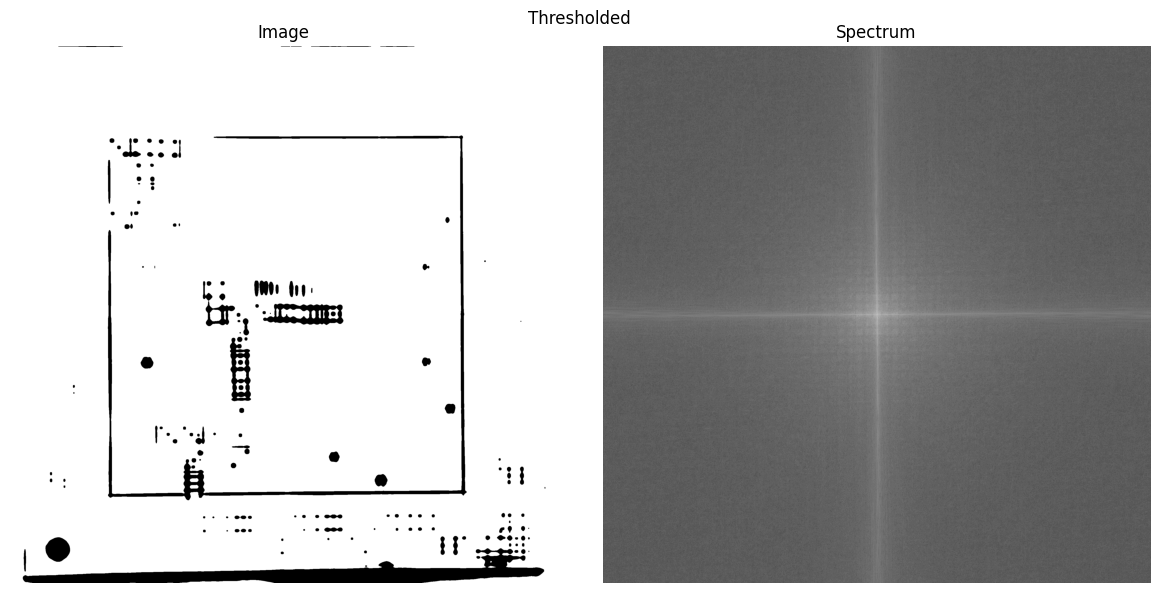

In [43]:
ret, image_treshholded = cv.threshold(image_masked, 200, 255, cv.THRESH_BINARY)
kernel = np.ones((3, 3), np.uint8)
image_treshholded = cv.erode(image_treshholded, kernel)
print_image(image_treshholded, title="Thresholded")

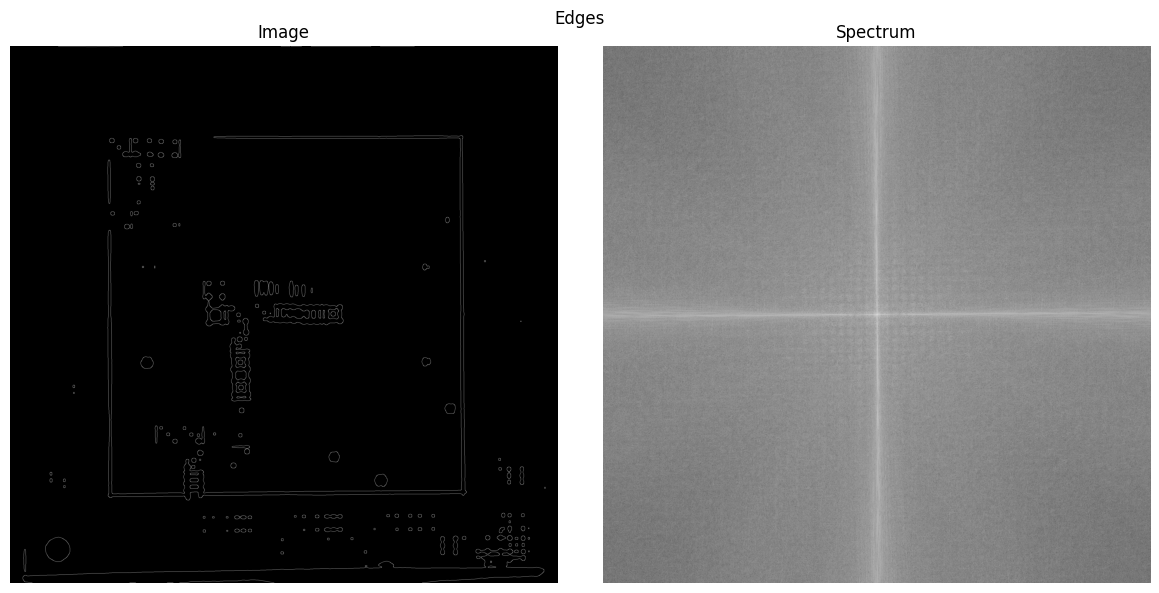

In [44]:
image_edges = cv.Canny(
    image=image_treshholded,
    threshold1=100,
    threshold2=255,
    apertureSize=5,
    L2gradient=True,
)
print_image(image_edges, title="Edges")

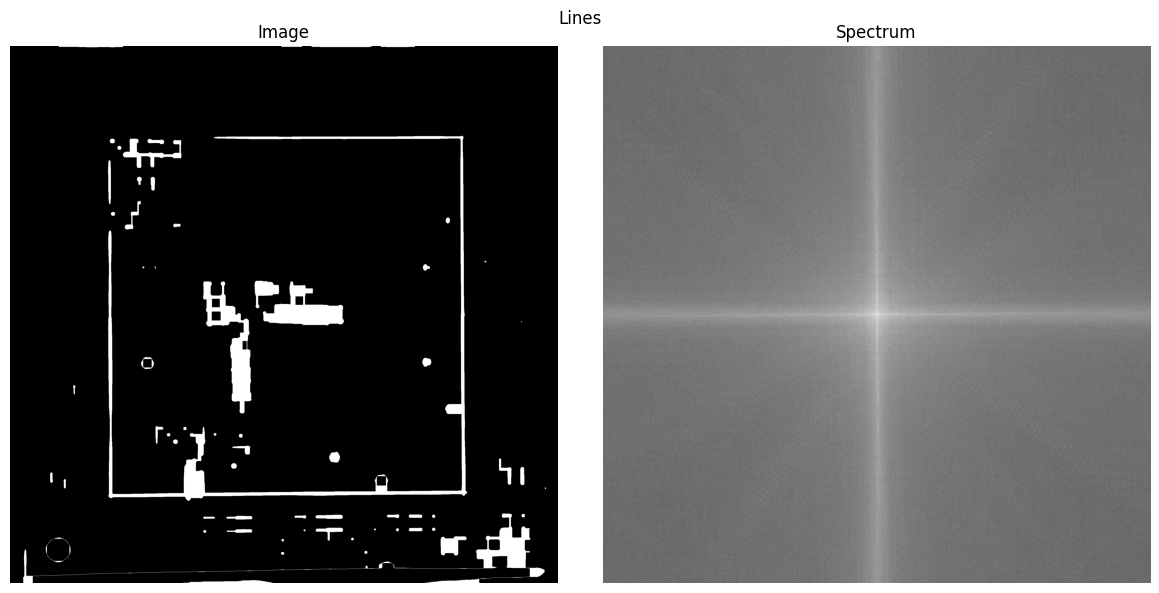

In [45]:
h_kernel = np.ones((1, 20), np.uint8)
v_kernel = np.ones((20, 1), np.uint8)


def connect_lines(image, kernel):
    d_im = cv.dilate(image, kernel, iterations=2)
    e_im = cv.erode(d_im, kernel, iterations=2)
    return e_im


image_lines = connect_lines(image_edges, h_kernel)
image_lines = connect_lines(image_lines, v_kernel)
print_image(image_lines, title="Lines")

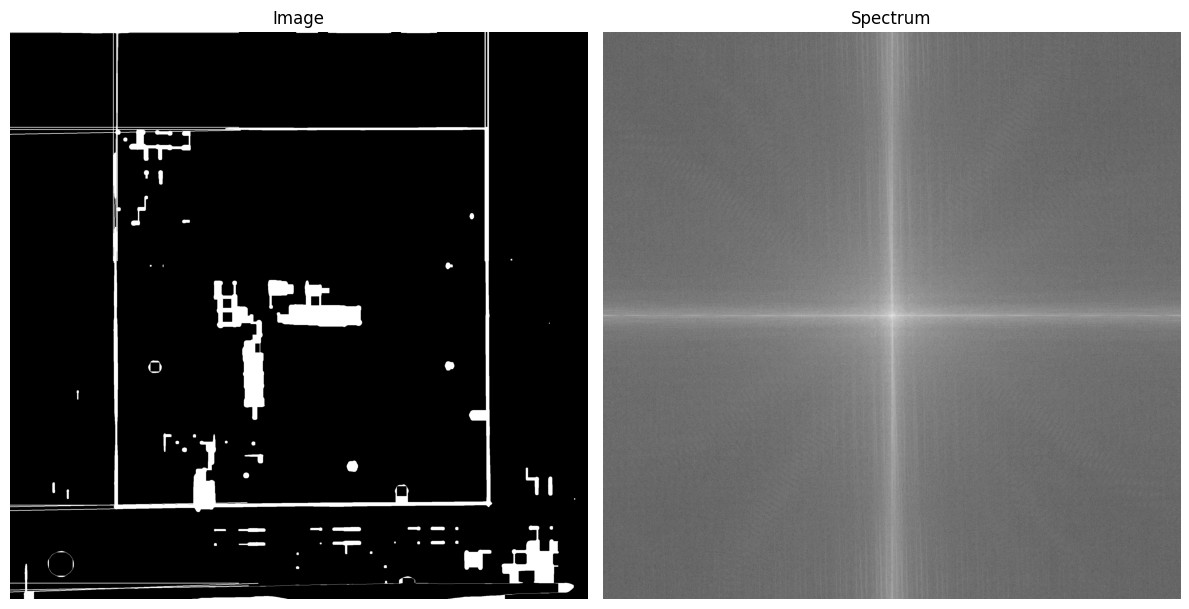

In [46]:
lines = cv.HoughLines(
    image_edges,
    rho=1,
    theta=np.pi / 180,
    threshold=200,
    srn=0,
    stn=0,
    min_theta=0,
    max_theta=9 * np.pi / 16,
)
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv.line(image_lines, (x1, y1), (x2, y2), (255, 255, 255), 2)

print_image(image_lines)

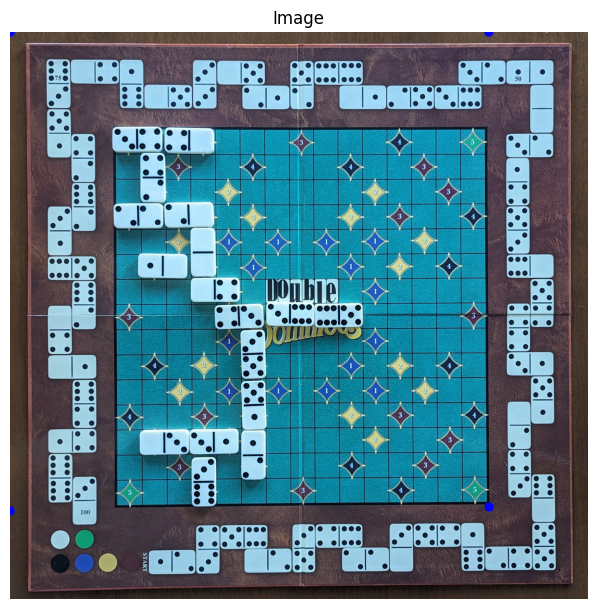

In [47]:
contours, _ = cv.findContours(image_lines, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
max_area = 0
for i in range(len(contours)):
    if len(contours[i]) > 3:
        possible_top_left = None
        possible_bottom_right = None
        for point in contours[i].squeeze():
            if (
                possible_top_left is None
                or point[0] + point[1] < possible_top_left[0] + possible_top_left[1]
            ):
                possible_top_left = point

            if (
                possible_bottom_right is None
                or point[0] + point[1]
                > possible_bottom_right[0] + possible_bottom_right[1]
            ):
                possible_bottom_right = point

        diff = np.diff(contours[i].squeeze(), axis=1)
        possible_top_right = contours[i].squeeze()[np.argmin(diff)]
        possible_bottom_left = contours[i].squeeze()[np.argmax(diff)]
        if (
            cv.contourArea(
                np.array(
                    [
                        [possible_top_left],
                        [possible_top_right],
                        [possible_bottom_right],
                        [possible_bottom_left],
                    ]
                )
            )
            > max_area
        ):
            max_area = cv.contourArea(
                np.array(
                    [
                        [possible_top_left],
                        [possible_top_right],
                        [possible_bottom_right],
                        [possible_bottom_left],
                    ]
                )
            )
            top_left = possible_top_left
            bottom_right = possible_bottom_right
            top_right = possible_top_right
            bottom_left = possible_bottom_left

width = 810
height = 810

cv.circle(image_copy, tuple(top_left), 20, (0, 0, 255), -1)
cv.circle(image_copy, tuple(top_right), 20, (0, 0, 255), -1)
cv.circle(image_copy, tuple(bottom_left), 20, (0, 0, 255), -1)
cv.circle(image_copy, tuple(bottom_right), 20, (0, 0, 255), -1)
print_image(image_copy, fft=False)

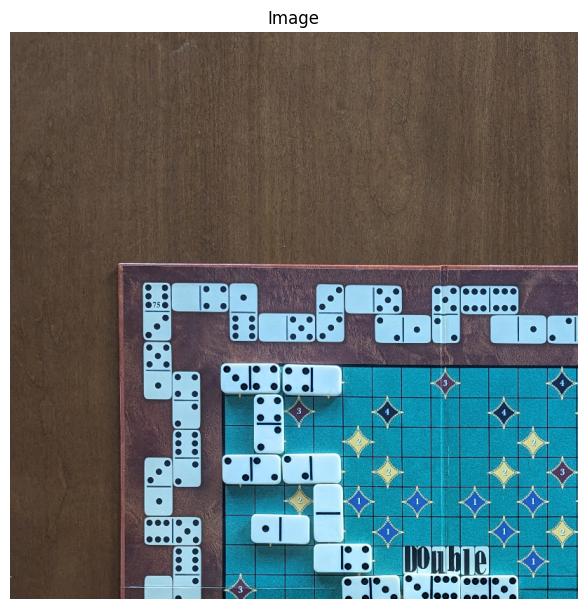

In [48]:
puzzle = np.array(
    [[top_left], [top_right], [bottom_right], [bottom_left]], dtype="float32"
)
destionation_puzzle = np.array(
    [[0, 0], [width, 0], [width, height], [0, height]], dtype="float32"
)
m = cv.getPerspectiveTransform(puzzle, destionation_puzzle)
result = cv.warpPerspective(image, m, (width, height))
result = cv.cvtColor(result, cv.COLOR_BGR2RGB)
print_image(result, fft=False)